In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 942ms/step - loss: 1.1265e-04
Average validation loss: 0.6571016907691956
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 965ms/step - loss: 1.1265e-04 - val_loss: 0.6571
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 922ms/step - loss: 9.1748e-05 - val_loss: 0.6571
Average validation loss: 0.6521382331848145
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - loss: 9.1748e-05 - val_loss: 0.6546
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 877ms/step - loss: 7.5745e-05 - val_loss: 0.6546
Average validation loss: 0.6897717714309692
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 893ms/step - loss: 7.5745e-05 - val_loss: 0.6663
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - loss: 6.4188e-05 - val_loss: 0.666

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 786ms/step - loss: 7.8814e-07
Average validation loss: 0.07987229339778423
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 795ms/step - loss: 7.8814e-07 - val_loss: 0.0799
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 794ms/step - loss: 8.1034e-07 - val_loss: 0.0799
Average validation loss: 0.05481254309415817
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 803ms/step - loss: 8.1034e-07 - val_loss: 0.0673
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - loss: 7.9344e-07 - val_loss: 0.0673
Average validation loss: 0.0681656263768673
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 803ms/step - loss: 7.9344e-07 - val_loss: 0.0676
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 788ms/step - loss: 7.8631e-07 - val_loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 791ms/step - loss: 3.9539e-07
Average validation loss: 0.03879217430949211
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 800ms/step - loss: 3.9539e-07 - val_loss: 0.0388
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 3.8552e-07 - val_loss: 0.0388
Average validation loss: 0.05014382364849249
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - loss: 3.8552e-07 - val_loss: 0.0445
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 787ms/step - loss: 3.6962e-07 - val_loss: 0.0445
Average validation loss: 0.04081406071782112
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 800ms/step - loss: 3.6962e-07 - val_loss: 0.0433
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 797ms/step - loss: 3.5641e-07 - val_loss: 0.0433
Average validation loss: 0.04922876072426637
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 808ms/step - loss: 3.5641e-07 - val_loss: 0.0447
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 873ms/step - loss: 2.0322e-07
Average validation loss: 0.01896223542280495
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - loss: 2.0322e-07 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 821ms/step - loss: 2.5274e-07 - val_loss: 0.0190
Average validation loss: 0.0324479746632278
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 831ms/step - loss: 2.5274e-07 - val_loss: 0.0257
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 847ms/step - loss: 2.4874e-07 - val_loss: 0.0257
Average validation loss: 0.01901703653857112
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 858ms/step - loss: 2.4874e-07 - val_loss: 0.0235
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 810ms/step - loss: 2.3425e-07 - val_loss: 0.0235
Average validation loss: 0.02837133826687932
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 821ms/step - loss: 2.3425e-07 - val_loss: 0.0247
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step - loss: 1.6450e-07
Average validation loss: 0.02347872881218791
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 806ms/step - loss: 1.6450e-07 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 785ms/step - loss: 1.7563e-07 - val_loss: 0.0235
Average validation loss: 0.018974557239562272
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 796ms/step - loss: 1.7563e-07 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 780ms/step - loss: 1.6913e-07 - val_loss: 0.0212
Average validation loss: 0.01696893386542797
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 790ms/step - loss: 1.6913e-07 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 976ms/step - loss: 3.0081e-07
Average validation loss: 0.01809325705592831
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 987ms/step - loss: 3.0081e-07 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 907ms/step - loss: 2.6332e-07 - val_loss: 0.0181
Average validation loss: 0.014228683275481066
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 918ms/step - loss: 2.6332e-07 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 777ms/step - loss: 2.2701e-07 - val_loss: 0.0162
Average validation loss: 0.015918012708425522
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 786ms/step - loss: 2.2701e-07 - val_loss: 0.0161
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 778ms/step - loss: 2.0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - loss: 2.9307e-07
Average validation loss: 0.051593313738703725
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - loss: 2.9307e-07 - val_loss: 0.0516
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 776ms/step - loss: 2.6555e-07 - val_loss: 0.0516
Average validation loss: 0.04786660592071712
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 2.6555e-07 - val_loss: 0.0497
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 778ms/step - loss: 2.3893e-07 - val_loss: 0.0497
Average validation loss: 0.0555747683160007
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 788ms/step - loss: 2.3893e-07 - val_loss: 0.0517
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 779ms/step - loss: 2.19

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 770ms/step - loss: 3.0244e-07
Average validation loss: 0.017453810161290068
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 3.0244e-07 - val_loss: 0.0175
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 782ms/step - loss: 2.3609e-07 - val_loss: 0.0175
Average validation loss: 0.023103769596976537
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 794ms/step - loss: 2.3609e-07 - val_loss: 0.0203
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 1.9810e-07 - val_loss: 0.0203
Average validation loss: 0.019557748067503173
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 793ms/step - loss: 1.9810e-07 - val_loss: 0.0200
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 788ms/step - loss: 1.7639e-07 - val_loss: 0.0200
Average validation loss: 0.018966755092454452
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 800ms/step - loss: 1.7639e-07 - val_loss: 0.0198


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 787ms/step - loss: 1.8852e-07
Average validation loss: 0.023120618857709423
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 798ms/step - loss: 1.8852e-07 - val_loss: 0.0231
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 808ms/step - loss: 1.7087e-07 - val_loss: 0.0231
Average validation loss: 0.01801450041654919
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 819ms/step - loss: 1.7087e-07 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 813ms/step - loss: 1.5623e-07 - val_loss: 0.0206
Average validation loss: 0.021635245066136122
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 824ms/step - loss: 1.5623e-07 - val_loss: 0.0209
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 184s 838ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 953ms/step - loss: 1.1486e-07
Average validation loss: 0.019338092126417905
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 964ms/step - loss: 1.1486e-07 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 113s 805ms/step - loss: 9.8655e-08 - val_loss: 0.0193
Average validation loss: 0.019586935348343104
64/64 ━━━━━━━━━━━━━━━━━━━━ 114s 816ms/step - loss: 9.8655e-08 - val_loss: 0.0195
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 777ms/step - loss: 9.2328e-08 - val_loss: 0.0195
Average validation loss: 0.016540114127565175
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 788ms/step - loss: 9.2328e-08 - val_loss: 0.0185
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 214s 776ms/step - los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 9.5351e-08
Average validation loss: 0.026114033431642585
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 9.5351e-08 - val_loss: 0.0261
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 779ms/step - loss: 8.9009e-08 - val_loss: 0.0261
Average validation loss: 0.037574021559622556
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 790ms/step - loss: 8.9009e-08 - val_loss: 0.0318
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 776ms/step - loss: 8.4208e-08 - val_loss: 0.0318
Average validation loss: 0.027340271044522524
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 787ms/step - loss: 8.4208e-08 - val_loss: 0.0303
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 777ms/step - loss: 7.6987e-08 - val_loss: 0.0303
Average validation loss: 0.02403734748562177
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 788ms/step - loss: 7.6987e-08 - val_loss: 0.0288

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - loss: 1.0008e-07
Average validation loss: 0.008955433941446244
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 1.0008e-07 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 784ms/step - loss: 8.2135e-08 - val_loss: 0.0090
Average validation loss: 0.020957282290328293
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 795ms/step - loss: 8.2135e-08 - val_loss: 0.0150
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 784ms/step - loss: 6.8719e-08 - val_loss: 0.0150
Average validation loss: 0.023547646938823164
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 6.8719e-08 - val_loss: 0.0178
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 254s 787ms/step - loss: 6.3821e-08 - val_loss: 0.0178
Average validation loss: 0.02049716031178832
80/80 ━━━━━━━━━━━━━━━━━━━━ 254s 797ms/step - loss: 6.3821e-08 - val_loss: 0.018

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 781ms/step - loss: 2.3214e-07
Average validation loss: 0.024417449138127267
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 793ms/step - loss: 2.3214e-07 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 778ms/step - loss: 1.8572e-07 - val_loss: 0.0244
Average validation loss: 0.033634502886949726
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 790ms/step - loss: 1.8572e-07 - val_loss: 0.0290
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 773ms/step - loss: 1.5891e-07 - val_loss: 0.0290
Average validation loss: 0.021972258827493835
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 785ms/step - loss: 1.5891e-07 - val_loss: 0.0267
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 302s 773ms/step - l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 785ms/step - loss: 1.4336e-07
Average validation loss: 0.02474569088080898
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 796ms/step - loss: 1.4336e-07 - val_loss: 0.0247
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 1.2419e-07 - val_loss: 0.0247
Average validation loss: 0.021044023552288613
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 806ms/step - loss: 1.2419e-07 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 805ms/step - loss: 1.2653e-07 - val_loss: 0.0229
Average validation loss: 0.02796585432079155
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 815ms/step - loss: 1.2653e-07 - val_loss: 0.0246
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 383s 77

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 775ms/step - loss: 2.2629e-07
Average validation loss: 0.02525231573155098
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 2.2629e-07 - val_loss: 0.0253
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 775ms/step - loss: 2.0240e-07 - val_loss: 0.0253
Average validation loss: 0.02149320395417615
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 2.0240e-07 - val_loss: 0.0234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 775ms/step - loss: 1.9555e-07 - val_loss: 0.0234
Average validation loss: 0.022236460040100308
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 786ms/step - loss: 1.9555e-07 - val_loss: 0.0230
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 123s 769ms/step - loss: 7.1492e-08
Average validation loss: 0.02318910699978005
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 7.1492e-08 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 774ms/step - loss: 6.4469e-08 - val_loss: 0.0232
Average validation loss: 0.015412644024763722
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 785ms/step - loss: 6.4469e-08 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 376s 787ms/step - loss: 6.0297e-08 - val_loss: 0.0193
Average validation loss: 0.01628208723341231
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 798ms/step - loss: 6.0297e-08 - val_loss: 0.0183
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 504s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 780ms/step - loss: 9.6729e-08
Average validation loss: 0.02673794345668284
200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 791ms/step - loss: 9.6729e-08 - val_loss: 0.0267
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 781ms/step - loss: 8.0584e-08 - val_loss: 0.0267
Average validation loss: 0.03073496709479514
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 791ms/step - loss: 8.0584e-08 - val_loss: 0.0287
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 472s 777ms/step - loss: 7.8738e-08 - val_loss: 0.0287
Average validation loss: 0.023238615128793754
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 788ms/step - loss: 7.8738e-08 - val_loss: 0.0269
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 632s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 776ms/step - loss: 1.1506e-07
Average validation loss: 0.030171487571213143
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 787ms/step - loss: 1.1506e-07 - val_loss: 0.0302
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 772ms/step - loss: 9.9223e-08 - val_loss: 0.0302
Average validation loss: 0.028764140864617125
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 783ms/step - loss: 9.9223e-08 - val_loss: 0.0295
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 775ms/step - loss: 8.5870e-08 - val_loss: 0.0295
Average validation loss: 0.02281389003252722
240/240 ━━━━━━━━━━━━━━━━━━━━ 565s 786ms/step - loss: 8.5870e-08 - val_loss: 0.0272
Saved model weights to 'c:\天_11157065\git\Ri

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11440472804009914, 0.045896646976470945, 0.03206647067641219, 0.0263776410673745, 0.021711572490632533, 0.019326836538190645, 0.028042963014915587, 0.022126611541801445, 0.023686106729853367, 0.021338825808197726, 0.02478817277769041, 0.029131946494337167, 0.028072015101594534, 0.029311849616123556, 0.03607283653370037, 0.036611341769457795, 0.03510214206497983, 0.03658938692292263]
std_val_losses =  [0.15544931560306402, 0.015155044864737947, 0.011074412230283907, 0.007644009180354512, 0.006061700865738918, 0.005856726810364148, 0.014597281368226318, 0.004980270671884674, 0.006590450766401629, 0.003933804380455587, 0.011301892271322568, 0.008674604404873618, 0.006213914790730107, 0.00906741612930769, 0.015411907094897039, 0.02250181982941839, 0.011963992181875159, 0.017589866842306942]


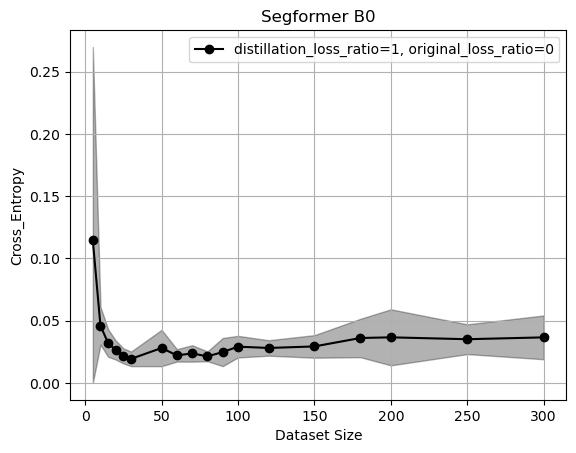

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()